<a href="https://colab.research.google.com/github/JCCamelo/MVP3_BANCO_DADOS/blob/main/MVP3_BANCO_DADOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introdução

O Governo brasileiro disponibiliza abertamente alguns dados no Portal da Transparência, no qual o cidadão pode encontrar informações sobre como o dinheiro público é utilizado, além de se informar sobre assuntos relacionados à gestão pública do Brasil.

Desta forma, este estudo tem como objetivo analisar os dados de orçamento de despesas das contas públicas, afim de responder quais departamento gastam mais recursos e com que tipo de ação estão gastando, para que o público possa saber o que aconteceu com o dinheiro dos brasileiros no ano de 2022.

Os dados foram retirados do link abaixo:
https://portaldatransparencia.gov.br/download-de-dados/orcamento-despesa

# 2. Coleta

Uma vez definido o tipo de dados que trabalharemos, vamos utilizá-los em um bucket no S3, um serviço da nuvem da Amazon para armazená-los, podendo assim utilizar de transformações mais a frente para análises.

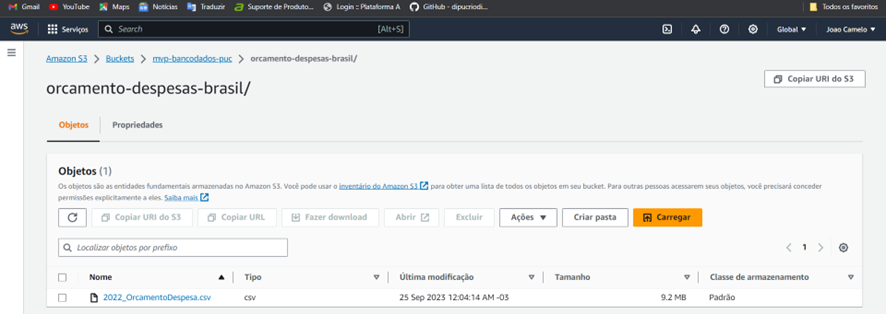

# 3. Modelagem

Nesta parte, os dados serão catalogados no AWS Glue, dizendo quais colunas serão trabalhadas e o que significa cada uma.

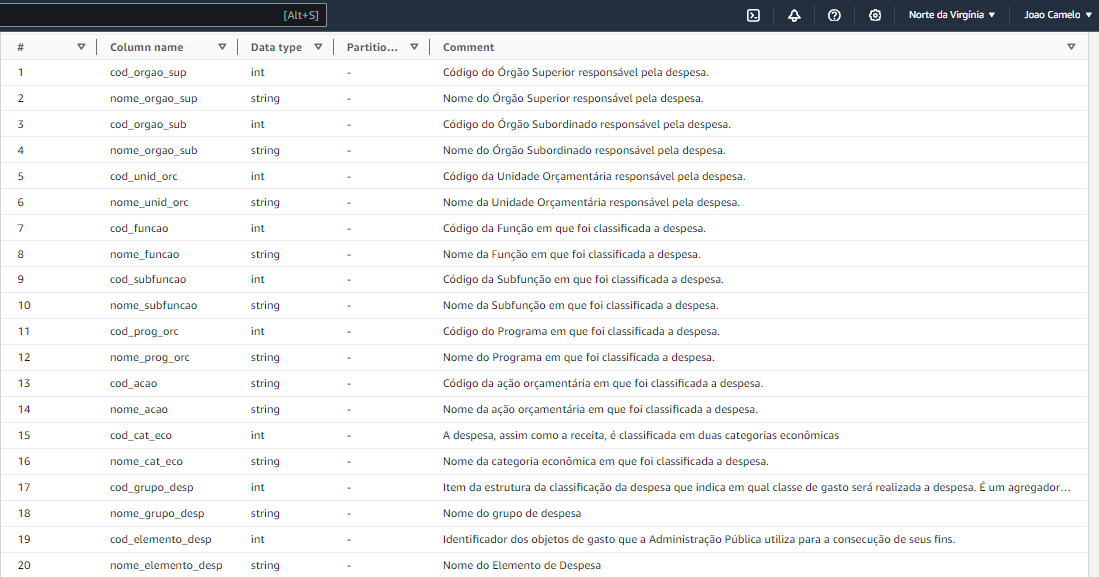

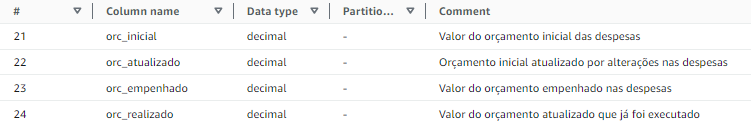

# 4. Carga

O processo de ETL foi realizado utilizando o serviço AWS Glue. Através de sua interface visual foram criadas as seguintes etapas na imagem abaixo:

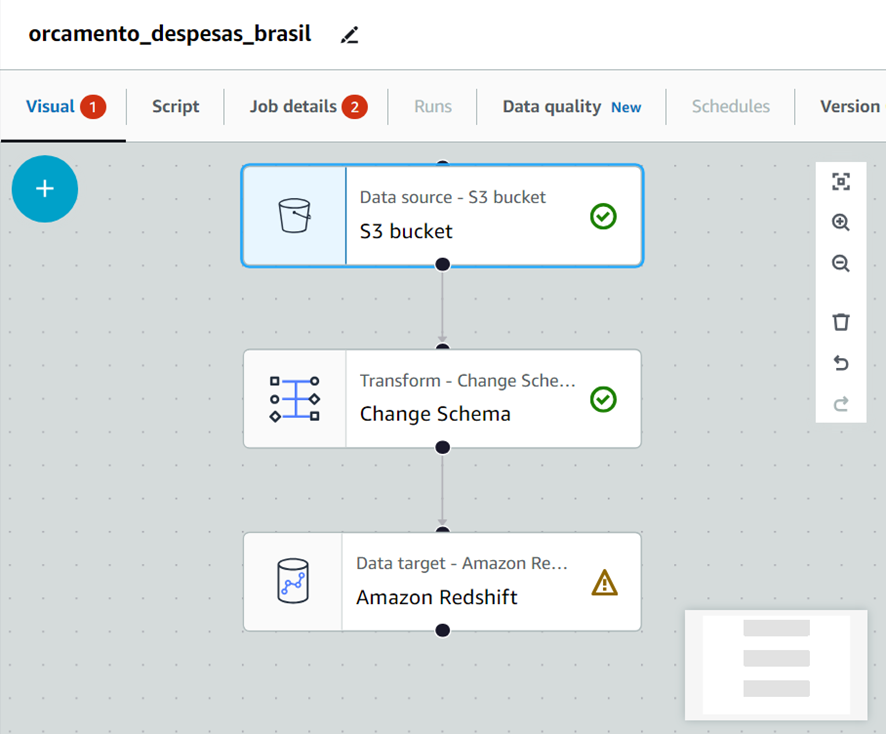

Na etapa 1, “Data source – S3 bucket”, foram realizadas as configurações para extrair (Extract) os dados da fonte, no caso a pasta “orçamento-despesas-brasil” do bucket “mvp-bancodados-puc”.

Na etapa 2, “Transform – Change Schema”, realizamos a etapa de transformação (Transform) dos dados, convertendo os tipos dos campos CÓDIGO ÓRGÃO SUPERIOR, CÓDIGO ÓRGÃO SUBORDINADO, CÓDIGO UNIDADE ORÇAMENTÁRIA, CÓDIGO FUNÇÃO, CÓDIGO SUBFUNÇÃO, CÓDIGO PROGRAMA ORÇAMENTÁRIO, CÓDIGO CATEGORIA ECONÔMICA, CÓDIGO GRUPO DE DESPESA e CÓDIGO ELEMENTO DE DESPESA para int.

Já os campos ORÇAMENTO INICIAL (R$), ORÇAMENTO ATUALIZADO (R$), ORÇAMENTO EMPENHADO (R$) e ORÇAMENTO REALIZADO R$ foram convertidos para float.

Por fim, o campo EXERCÍCIO foi excluído da tabela, pois todos os dados pertencem ao ano de 2022.

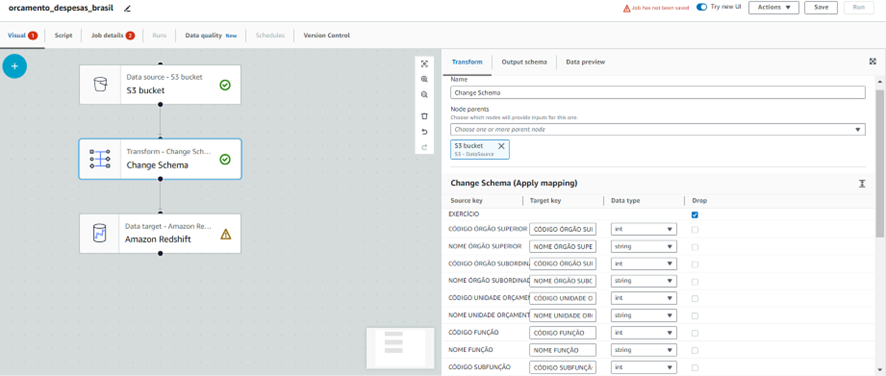

Já na terceira etapa, “Data target – Amazon Redshift”, configuramos os parâmetros necessários para o carregamento (Load) dos dados transformados no nosso banco de dados.

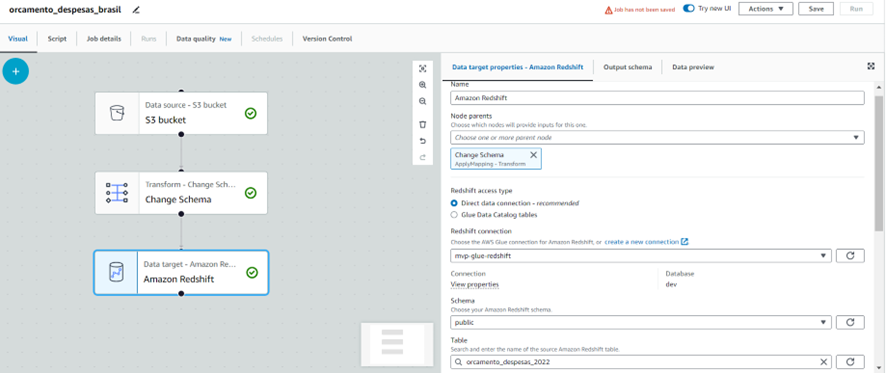

Por último, registramos a execução dos jobs após todas as configurações.

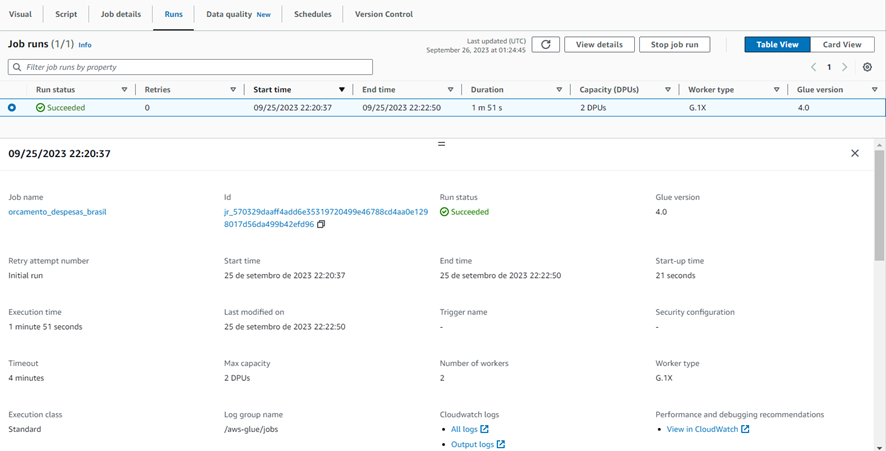

# 5. Análise

Para começar a análise, é preciso identificar que a base de dados utilizada é de boa qualidade e que está pronta para gerar insights. Desta forma, é importado alguns pacotes para que ajude nas análises, carregando de um arquivo .csv do pacote Pandas (Python Data Analysis Library).

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from datetime import datetime

In [ ]:
url = "https://raw.githubusercontent.com/JCCamelo/MVP3_BANCO_DADOS/main/2022_OrcamentoDespesa.csv"

# Informa o cabeçalho das colunas
colunas = ['ano', 'cod_orgao_sup', 'nome_orgao_sup', 'cod_orgao_sub', 'nome_orgao_sub',
           'cod_unid_orc', 'nome_unid_orc', 'cod_funcao', 'nome_funcao', 'cod_subfuncao',
           'nome_subfuncao', 'cod_prog_orc', 'nome_prog_orc', 'cod_acao', 'nome_acao',
           'cod_cat_eco', 'nome_cat_eco', 'cod_grupo_desp', 'nome_grupo_desp', 'cod_elemento_desp',
           'nome_elemento_desp', 'orc_inicial', 'orc_atualizado', 'orc_empenhado', 'orc_realizado']

# Lê o arquivo utilizando as colunas informadas
dataset = pd.read_csv(url, names=colunas, skiprows=1, delimiter=';')

No comando abaixo, podemos ver todas as colunas e seus respectivos dados.

In [ ]:
dataset.head()

,ano,cod_orgao_sup,nome_orgao_sup,cod_orgao_sub,nome_orgao_sub,cod_unid_orc,nome_unid_orc,cod_funcao,nome_funcao,cod_subfuncao,...,cod_cat_eco,nome_cat_eco,cod_grupo_desp,nome_grupo_desp,cod_elemento_desp,nome_elemento_desp,orc_inicial,orc_atualizado,orc_empenhado,orc_realizado
0,2022,20000,Presidência da República,20101,Presidência da República,20101,PRESIDENCIA DA REPUBLICA,4,Administração,122,...,4,DESPESAS DE CAPITAL,4,Investimentos,51,Obras e Instalações,"5797530,99","5797530,99","5797530,99","1755185,23"
1,2022,20000,Presidência da República,20101,Presidência da República,20101,PRESIDENCIA DA REPUBLICA,4,Administração,122,...,3,DESPESAS CORRENTES,3,Outras Despesas Correntes,30,Material de Consumo,"1446919,74","1446919,74","1446919,74","1446919,74"
2,2022,20000,Presidência da República,20101,Presidência da República,20101,PRESIDENCIA DA REPUBLICA,4,Administração,122,...,3,DESPESAS CORRENTES,3,Outras Despesas Correntes,40,Serviços de Tecnologia da Informação e Comunic...,"168630,78","168630,78","168630,78",0
3,2022,20000,Presidência da República,20101,Presidência da República,20101,PRESIDENCIA DA REPUBLICA,4,Administração,122,...,3,DESPESAS CORRENTES,3,Outras Despesas Correntes,0,Não informado,"2144449,48","21903,48",0,0
4,2022,20000,Presidência da República,20101,Presidência da República,20101,PRESIDENCIA DA REPUBLICA,4,Administração,122,...,4,DESPESAS DE CAPITAL,4,Investimentos,0,Não informado,"30248301,79","66831,79",0,0


Neste código, conseguimos ver todas as colunas e que nenhuma está com dados faltando, todas estão completas.

In [ ]:
# Mostra as informações do dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23643 entries, 0 to 23642
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ano                 23643 non-null  int64 
 1   cod_orgao_sup       23643 non-null  int64 
 2   nome_orgao_sup      23643 non-null  object
 3   cod_orgao_sub       23643 non-null  int64 
 4   nome_orgao_sub      23643 non-null  object
 5   cod_unid_orc        23643 non-null  int64 
 6   nome_unid_orc       23643 non-null  object
 7   cod_funcao          23643 non-null  int64 
 8   nome_funcao         23643 non-null  object
 9   cod_subfuncao       23643 non-null  int64 
 10  nome_subfuncao      23643 non-null  object
 11  cod_prog_orc        23643 non-null  int64 
 12  nome_prog_orc       23643 non-null  object
 13  cod_acao            23643 non-null  object
 14  nome_acao           23643 non-null  object
 15  cod_cat_eco         23643 non-null  int64 
 16  nome_cat_eco        23

Abaixo, as colunas orc_inicial, orc_atualizado, orc_empenhado, orc_realizado foram convertidas para números decimais (float), pois são dados de valores monetários.

In [ ]:
dataset['orc_inicial'] = dataset['orc_inicial'].str.replace(',', '.')
dataset['orc_atualizado'] = dataset['orc_atualizado'].str.replace(',', '.')
dataset['orc_empenhado'] = dataset['orc_empenhado'].str.replace(',', '.')
dataset['orc_realizado'] = dataset['orc_realizado'].str.replace(',', '.')

# Converta as colunas para o tipo de dados float
dataset['orc_inicial'] = dataset['orc_inicial'].astype(float)
dataset['orc_atualizado'] = dataset['orc_atualizado'].astype(float)
dataset['orc_empenhado'] = dataset['orc_empenhado'].astype(float)
dataset['orc_realizado'] = dataset['orc_realizado'].astype(float)

print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23643 entries, 0 to 23642
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ano                 23643 non-null  int64  
 1   cod_orgao_sup       23643 non-null  int64  
 2   nome_orgao_sup      23643 non-null  object 
 3   cod_orgao_sub       23643 non-null  int64  
 4   nome_orgao_sub      23643 non-null  object 
 5   cod_unid_orc        23643 non-null  int64  
 6   nome_unid_orc       23643 non-null  object 
 7   cod_funcao          23643 non-null  int64  
 8   nome_funcao         23643 non-null  object 
 9   cod_subfuncao       23643 non-null  int64  
 10  nome_subfuncao      23643 non-null  object 
 11  cod_prog_orc        23643 non-null  int64  
 12  nome_prog_orc       23643 non-null  object 
 13  cod_acao            23643 non-null  object 
 14  nome_acao           23643 non-null  object 
 15  cod_cat_eco         23643 non-null  int64  
 16  nome

Nesta parte, é demonstrado que nenhuma das colunas possuem dados nulos, assim todas as linhas tem informações relevantes.

In [ ]:
# verificando nulls no dataset
dataset.isnull().sum()

ano                   0
cod_orgao_sup         0
nome_orgao_sup        0
cod_orgao_sub         0
nome_orgao_sub        0
cod_unid_orc          0
nome_unid_orc         0
cod_funcao            0
nome_funcao           0
cod_subfuncao         0
nome_subfuncao        0
cod_prog_orc          0
nome_prog_orc         0
cod_acao              0
nome_acao             0
cod_cat_eco           0
nome_cat_eco          0
cod_grupo_desp        0
nome_grupo_desp       0
cod_elemento_desp     0
nome_elemento_desp    0
orc_inicial           0
orc_atualizado        0
orc_empenhado         0
orc_realizado         0
dtype: int64

In [ ]:
# seleciona a coluna 'nome_orgao_sup'
coluna_nome_orgao_sup = dataset['nome_orgao_sup']

# conta a quantidade de ocorrências de cada categoria
categorias_nome_orgao_sup = coluna_nome_orgao_sup.value_counts()

# exibe as categorias encontradas
print(categorias_nome_orgao_sup)

Ministério da Educação                                                          10438
Ministério da Defesa                                                             1925
Ministério da Saúde                                                              1320
Ministério da Fazenda                                                             993
Ministério da Integração e do Desenvolvimento Regional                            930
Ministério da Ciência, Tecnologia e Inovação                                      834
Ministério de Minas e Energia                                                     819
Ministério dos Transportes                                                        806
Ministério do Meio Ambiente e Mudança do Clima                                    613
Ministério da Agricultura e Pecuária                                              572
Ministério da Justiça e Segurança Pública                                         547
Ministério da Cultura                                 

Nesta etapa, confirmamos que não existe nenhum valor monetário negativo, demonstrando que todos são maiores que 0, aferindo a qualidade e veracidade dos dados.

In [ ]:
# seleciona a coluna 'nome_orgao_sup'
coluna_orc_realizado = dataset['orc_realizado']

# conta a quantidade de ocorrências de cada categoria
categorias_orc_realizado = coluna_orc_realizado.value_counts()

# exibe as categorias encontradas com o valor minimo
print(categorias_orc_realizado.min())

1


Com a análise concluída de todos os campos que será usado na análise no Redshift, com o código abaixo será gerada uma planilha nova para que possamos utilizá-la no S3 do serviço da Amazon.

In [ ]:
dataset.to_csv("/content/drive/My Drive/orcamento_despesa_vf.csv", index=False)

No Redshift, foi criado a tabela com todos os elementos, preparando para a análise para sabermos onde o Governo utilizou mais dos seus recursos.

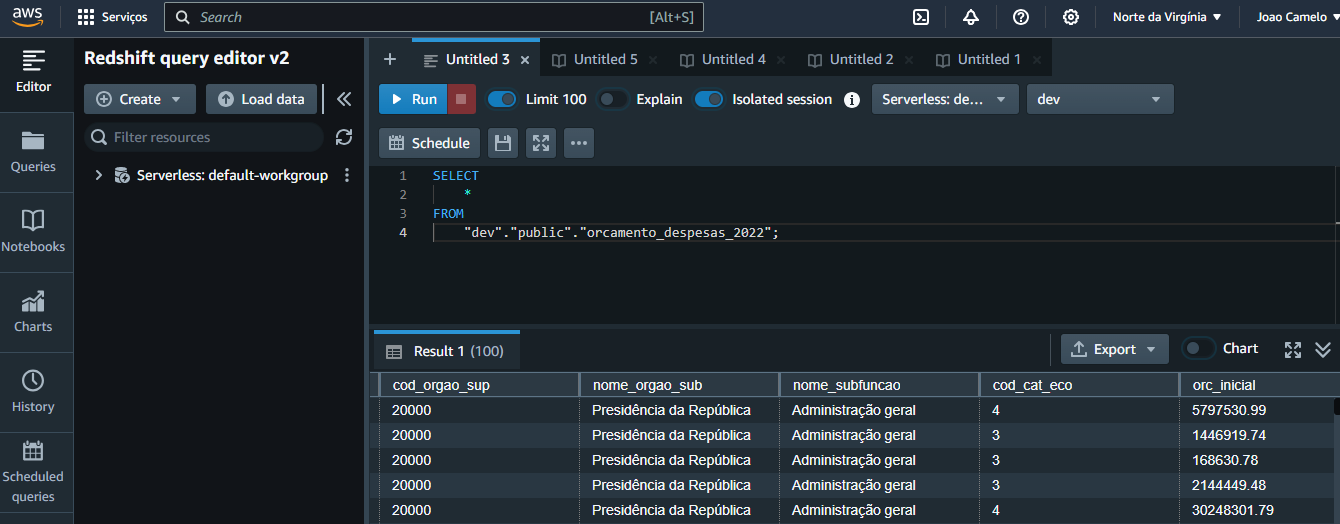



Agora com a tabela já preparada, será possível fazer consultas por Queries no Redshift para responder as perguntas. Quais Órgãos Superiores utilizaram de mais orçamento e de quantos reais? Quais os programas do Governo que utilizaram de mais orçamento e quanto foi ao total?

Os Órgãos Superiores que utilizaram mais orçamento está listado abaixo:

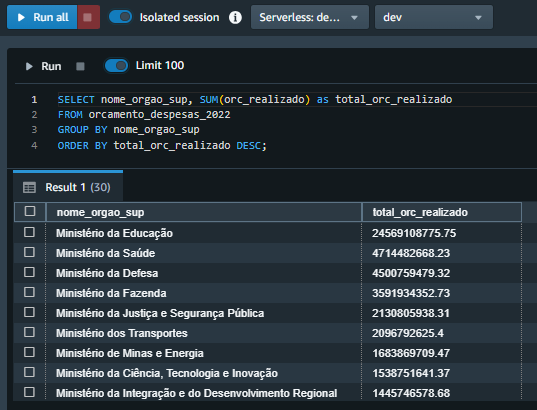

Os programas do Governo que mais utilizaram de orçamento foram os listados abaixo:

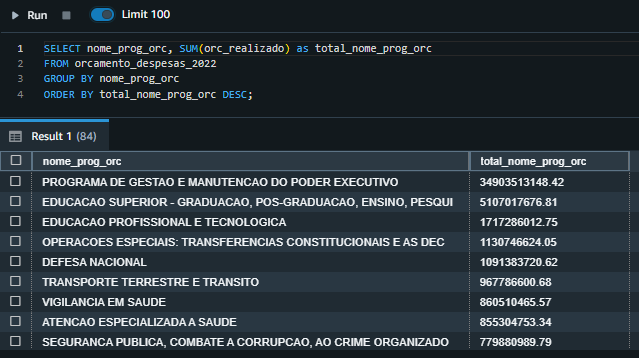